In [ ]:
import ray
ray.init()
# ray.shutdown()

In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('float_format', '{:f}'.format)

import pandas_bokeh
import matplotlib as mpl
from matplotlib import style
style.use('fivethirtyeight')
mpl.rcParams['figure.figsize'] = [20, 7]

import market_preprocess as mp
import market_cluster as mc
import polygon_ds as pds
import polygon_df as pdf
import polygon_s3 as ps3
import ray_symbol_details as rsd
import utils_pickle as up
# import ipdb
# ipdb.set_trace(context=10)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
start_date = '2018-10-24'
end_date = '2020-11-24'
symbol = 'market'
tick_type='daily'

In [4]:
df, sym_meta, m_close, m_returns, m_log_returns, m_zs_returns, m_g_zs_returns = mp.prepare_data(start_date, end_date)

4502494 Initial rows 11509 symbols
-1460110 all dates filter 5784 symbols
-383980 liquidity filter 5054 symbols
-125188 volitility filter 4816 symbols
-24196 min $value filter 4770 symbols
-706944 symbol details filter 3426 symbols
1802076 Final rows 40.0 % remaining


In [34]:
import matplotlib.pyplot as plt

cor_mat = m_g_zs_returns.corr()

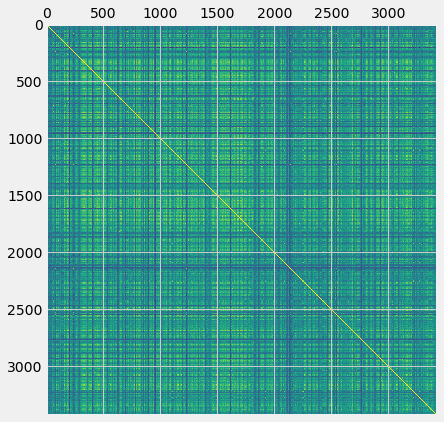

In [48]:
plt.matshow(cor_mat)

In [ ]:
import market_cov as mcov

cov_mat, cor_mat = mcov.cov_denoise_detone(m_g_zs_returns)

In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
# from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA as PCA
pca = PCA(n_components=10)
pca.fit(m_g_zs_returns)

market_pca_01 = pd.DataFrame({'symbol': m_g_zs_returns.columns, 'pca_0': pca.components_[0, :], 'pca_1': pca.components_[1, :]})

In [ ]:
pca_comps = pd.Series(pca.components_[0, :])

pca_comps[pca_comps>0].hist(bins=100)

In [ ]:
market_pca_01.sort_values('pca_0', ascending=False)[0:10]

In [ ]:
corex300 = up.pickle_load('data/corex300.pkl')

# X = df.reset_index(drop=True)
# corex, full_df = mc.corex_fit(X, n_hidden=200)

# up.pickle_dump((corex, full_df), file_name='corex200.pkl')

# gsutil copy /Users/bobcolner/QuantClarity/pandas-polygon/corex200.pkl gs://emerald-skill-datascience/

In [ ]:
import h2o
from h2o.estimators import H2OGeneralizedLowRankEstimator
h2o.init()

# Import the USArrests dataset into H2O:
arrestsH2O = h2o.import_file("https://s3.amazonaws.com/h2o-public-test-data/smalldata/pca_test/USArrests.csv")

# Split the dataset into a train and valid set:
train, valid = arrestsH2O.split_frame(ratios=[.8], seed=1234)

# Build and train the model:
glrm_model = H2OGeneralizedLowRankEstimator(
    k=4,
    loss="Huber",
    loss_by_col={'cat_var': 'Categorical'},
    regularization_x="OneSparse", # None (default), Quadratic, L2, L1, NonNegative, OneSparse, UnitOneSparse, Simplex.
    regularization_y="OneSparse",
    gamma_x=0.5,
    gamma_y=0.5,
    max_iterations=1000,
    recover_svd=True,
    init="PlusPlus",
    transform="standardize",
   )
glrm_model.train(training_frame=train)

In [ ]:
### market clustering

# %time df = read_market_daily(result_path)
mdf = pd.read_parquet('data/old/mdf.parquet')

%time npdf, sharpe_ratios = mc.normalize_market_df(mdf)

# %time npdf_resid = colwise_linreg(npdf)
npdf_resid = pd.read_parquet('data/old/npdf_resid.parquet')

# %time par_cor_mat = npdf_resid.corr()
resid_par_cor_mat = pd.read_parquet('data/old/partial_cor_mat.parquet')

details_df = pd.read_parquet('data/old/details_df.parquet')

# cluster_lables = cluster_sim_matrix(similarity=resid_par_cor_mat.abs())
cluster_lables = pd.read_parquet('data/old/cluster_lables.parquet')

# symbol_meta = join_symbol_data(details_df, cluster_lables, sharpe_ratios, mdf)
symbol_meta = pd.read_parquet('data/old/symbol_meta.parquet')

# cluster_coheasion = mc.get_cluster_coheasion(sim_df=resid_par_cor_mat.abs(), symbol_meta=symbol_meta, cluster_col='cluster_n200')

In [ ]:
symbol_meta['liquidy_rank'] = symbol_meta.groupby('cluster_n200')['daily_avg_dollar_volume'].rank(method='first')

symbol_meta = symbol_meta.sort_values(['cluster_n200', 'liquidy_rank']).reset_index()

by_cluster = symbol_meta.groupby('cluster_n200')
result = []
for cluster, frame in by_cluster:
    counts = dict(frame['sector'].value_counts())
    counts.pop('', None)  # drop symbols w/o sector/industry info
    result.append(counts)

In [ ]:
cluster_sec = pd.DataFrame(result)    
cluster_sec = cluster_sec.drop(columns=['Finance'])
cluster_sec_pct = cluster_sec.apply(lambda x: 100 * x / float(x.sum()), axis=1)

cluster_sec_pct.style.background_gradient(cmap='coolwarm', axis=0)

# n += 1
n = 61
print(n)
symbol_meta[symbol_meta.cluster_n200 == n].sector.value_counts()

sym_clust = symbol_meta[symbol_meta.cluster_n200 == n]
sym_clust